## Fully-connected, deep network for final 

In [1]:
import torch

from TrainingFramework import TrainingFramework, plot_hist, end_of_hist_result
from torch import nn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
class FcDeep(nn.Module):
    
    def __init__(self, weight_sharing=False, auxiliary_loss=False):
        
        super(FcDeep, self).__init__()
        
        self.input_size = 196
        self.aux_output_size = 10
        self.main_output_size = 2
        
        self.weight_sharing = weight_sharing
        self.auxiliary_loss = auxiliary_loss
        
        # Create first pipe
        self.pipe1 = self.__create_pipe()

        # Depending on WS, create second pipe or use the same
        #self.pipe2 = self.pipe1 if self.weight_sharing is True else self.__create_pipe()
        if self.weight_sharing:
            self.pipe2 = self.pipe1
        else:
            self.pipe2 = self.__create_pipe()
            
        # Create final classifier
        self.classifier = self.__create_classifier()

    def __create_pipe(self): 
        return nn.Sequential(
                nn.Linear(self.input_size, 300),
                #nn.Dropout(), 
                nn.ReLU(True),
                nn.Linear(300, 100),
                nn.ReLU(True),
                nn.Linear(100, 70),
                nn.ReLU(True),
                nn.Linear(70, 30),
                #nn.Dropout(), 
                nn.ReLU(True),
                nn.Linear(30, 20),
                nn.ReLU(True),
                nn.Linear(20, self.aux_output_size),
            )
    
    def __create_classifier(self):
        return nn.Sequential(
                nn.Linear(self.aux_output_size * 2, 30),
                nn.ReLU(True),
                nn.Linear(30, 20),
                nn.ReLU(True),
                nn.Linear(20, 10),
                nn.ReLU(True),
                nn.Linear(10, self.main_output_size)
            )
        
    def forward(self, x):        
        x1 = x[:,0:1,:,:]
        x2 = x[:,1:2,:,:]
        
        x1_pipe = self.pipe1(x1.view(-1, self.input_size))
        x2_pipe = self.pipe2(x2.view(-1, self.input_size))
        
        x_main = torch.cat([x1_pipe, x2_pipe], dim=1)
        x_main = self.classifier(x_main)
        
        return x_main if self.auxiliary_loss is False else (x_main, (x1_pipe, x2_pipe))
    
    def count_parameters(self) : 
        nb_params = 0
        for parameter in self.parameters():
            nb_params = nb_params + parameter.numel()
        return nb_params

prefix="DeepFC_"
niter = 10
nepoch = 50
auxweight = 0.50

FcDeep().count_parameters(), FcDeep(weight_sharing=True).count_parameters()

(199942, 100712)

## No aux, no weight sharing

'Epoch 50/50'

,train_loss,train_acc,val_loss,val_acc,aux_train_loss,aux_train_acc,aux_val_loss,aux_val_acc,epoch
last,0.019696,0.9976,1.398156,0.8149,NaN,NaN,NaN,NaN,49
best,0.024142,0.9978,1.181318,0.8176,NaN,NaN,NaN,NaN,33


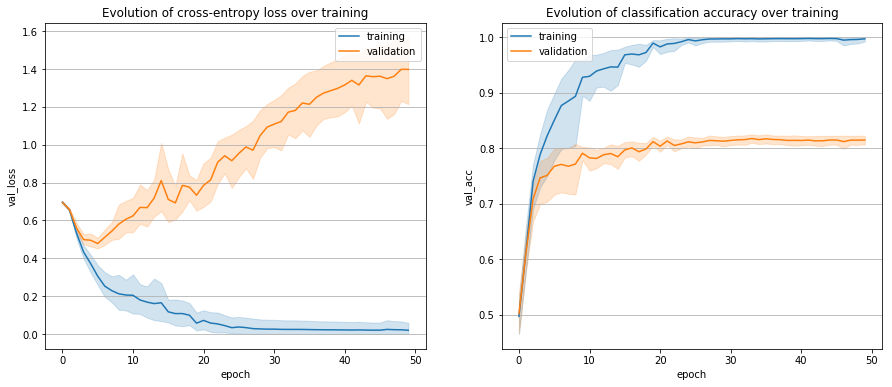

[7.925335754174739, 7.499562437646091, 7.492236161604524, 8.33191781397909, 12.204706353135407, 22.903285016305745, 13.249968430027366, 11.416216488927603, 7.607802956365049, 7.871411107946187]


In [3]:
tfNN = TrainingFramework(batchsize=100, mainLoss=nn.CrossEntropyLoss(), auxLoss=None)
hNN, tNN = tfNN.validateModel(FcDeep, auxLossWeight=auxweight, nb_iter=niter, epochs=nepoch)
hNN.to_csv('./histories/'+prefix+'noWS_noAux.csv', encoding='utf-8')
plot_hist(hNN, auxloss=False)
print(tNN)

## Auxiliary loss, no weight sharing

'Epoch 50/50'

,train_loss,train_acc,val_loss,val_acc,aux_train_loss,aux_train_acc,aux_val_loss,aux_val_acc,epoch
last,0.000182,1.0000,0.616538,0.8908,0.000328,1.0000,0.630351,0.9069,49
best,0.006362,0.9993,0.453160,0.8934,0.006190,0.9994,0.532520,0.9040,27


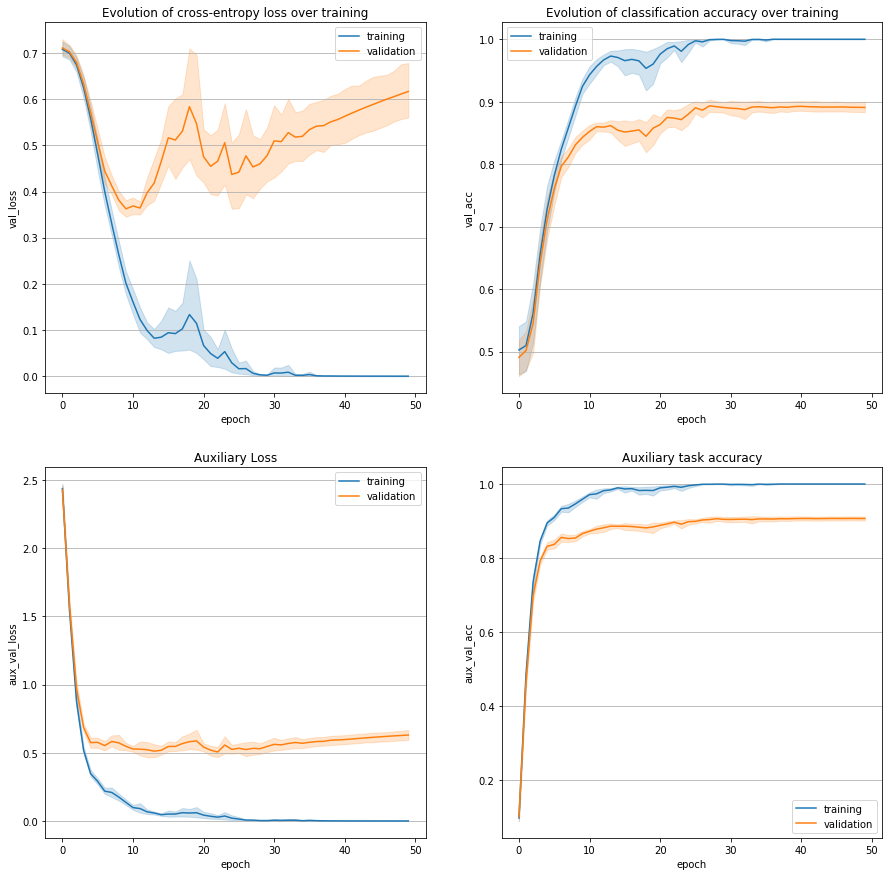

[9.76598000433296, 9.735205951612443, 10.02107428619638, 9.762844929937273, 9.812496141064912, 9.877897962927818, 9.801093460060656, 9.925978114828467, 9.768987091258168, 9.704092203173786]


In [4]:
tfNN = TrainingFramework(batchsize=100, mainLoss=nn.CrossEntropyLoss(), auxLoss=nn.CrossEntropyLoss())
hNN, tNN = tfNN.validateModel(lambda: FcDeep(auxiliary_loss=True), auxLossWeight=auxweight, nb_iter=niter, epochs=nepoch)
hNN.to_csv('./histories/'+prefix+'noWS_yesAux.csv', encoding='utf-8')
plot_hist(hNN)
print(tNN)

## No Auxiliary loss, Weight sharing

'Epoch 50/50'

,train_loss,train_acc,val_loss,val_acc,aux_train_loss,aux_train_acc,aux_val_loss,aux_val_acc,epoch
last,0.000026,1.0000,1.364490,0.8473,NaN,NaN,NaN,NaN,49
best,0.000602,0.9999,1.096585,0.8495,NaN,NaN,NaN,NaN,23


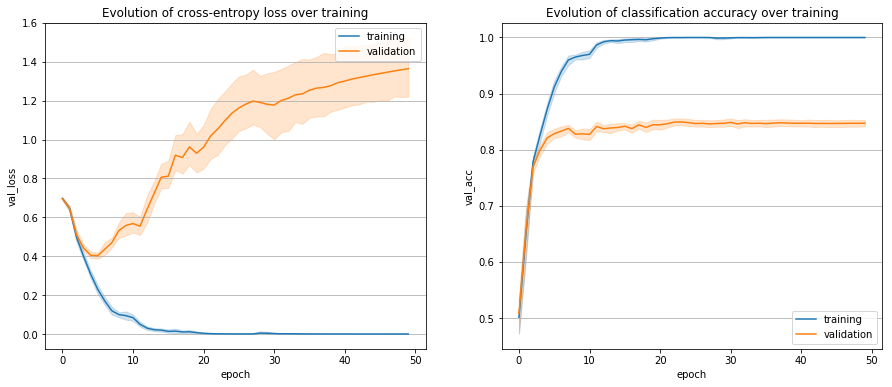

[7.302606695331633, 6.449337467551231, 6.295657675247639, 5.775622248183936, 5.758533448912203, 12.573368296027184, 13.855736698955297, 9.558347307611257, 6.649627405684441, 7.055650620255619]


In [5]:
tfNN = TrainingFramework(batchsize=100, mainLoss=nn.CrossEntropyLoss(), auxLoss=None)
hNN, tNN = tfNN.validateModel(lambda: FcDeep(weight_sharing=True), auxLossWeight=auxweight, nb_iter=niter, epochs=nepoch)
hNN.to_csv('./histories/'+prefix+'yesWS_noAux.csv', encoding='utf-8')
plot_hist(hNN, auxloss=False)
print(tNN)

## Auxiliary loss + weight sharing

'Epoch 50/50'

,train_loss,train_acc,val_loss,val_acc,aux_train_loss,aux_train_acc,aux_val_loss,aux_val_acc,epoch
last,0.000133,1.0000,0.612149,0.9004,0.000383,1.0000,0.434395,0.93165,49
best,0.001131,0.9999,0.484776,0.9035,0.002074,0.9999,0.382941,0.93135,28


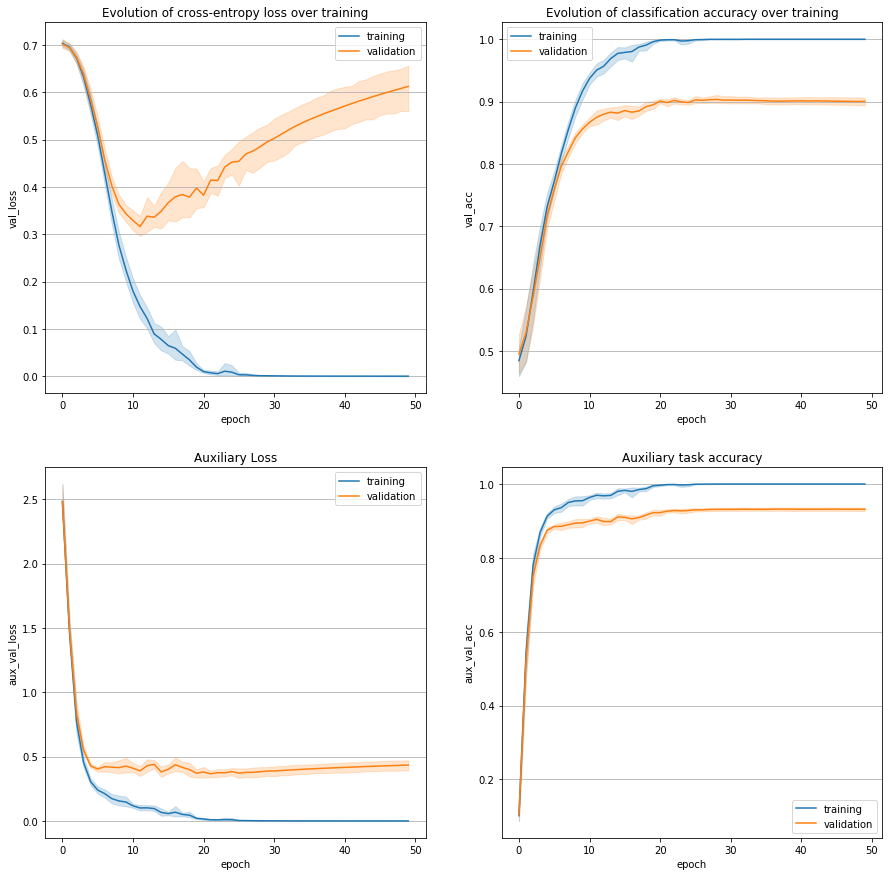

[10.440269149839878, 9.265750181861222, 9.110871034674346, 9.131927649024874, 9.125439148396254, 9.712660442106426, 9.331648538820446, 9.156341792084277, 8.983819973655045, 9.074023054912686]


In [7]:
tfNN = TrainingFramework(batchsize=100, mainLoss=nn.CrossEntropyLoss(), auxLoss=nn.CrossEntropyLoss())
hNN, tNN = tfNN.validateModel(lambda: FcDeep(weight_sharing=True, auxiliary_loss=True), auxLossWeight=auxweight, nb_iter=niter, epochs=nepoch)
hNN.to_csv('./histories/'+prefix+'yesWS_yesAux.csv', encoding='utf-8')
plot_hist(hNN)
print(tNN)